In [2]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/tmp/ipykernel_561564/271190350.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import zipfile

zip_file_path = "/home/chaitanya/Untitled_Folder/mlds-assignment-2.zip"

extract_path = "/home/chaitanya/Untitled_Folder/extracted_mlds_files" 


with zipfile.ZipFile(zip_file_path, "r") as zip_ref:

    zip_ref.extractall(extract_path)

print("Files extracted successfully to:", extract_path)


Files extracted successfully to: /home/chaitanya/Untitled_Folder/extracted_mlds_files


In [17]:
df1=pd.read_csv('/home/chaitanya/Untitled_Folder/extracted_mlds_files/sample_submission.csv')
df1

,id,binary_pred,segmentation_pred
0,Img_919.png,0,Healthy
1,Img_920.png,0,Healthy
2,Img_921.png,0,Healthy
3,Img_922.png,0,Healthy
4,Img_923.png,0,Healthy
...,...,...,...
389,Img_1308.png,0,Healthy
390,Img_1309.png,0,Healthy
391,Img_1310.png,0,Healthy
392,Img_1311.png,0,Healthy


In [18]:
df2=pd.read_csv('/home/chaitanya/Untitled_Folder/extracted_mlds_files/test.csv')
df2

,id,binary_pred,segmentation_pred
0,Img_919.png,NaN,NaN
1,Img_920.png,NaN,NaN
2,Img_921.png,NaN,NaN
3,Img_922.png,NaN,NaN
4,Img_923.png,NaN,NaN
...,...,...,...
389,Img_1308.png,NaN,NaN
390,Img_1309.png,NaN,NaN
391,Img_1310.png,NaN,NaN
392,Img_1311.png,NaN,NaN


In [19]:
df3=pd.read_csv('/home/chaitanya/Untitled_Folder/extracted_mlds_files/train.csv')
df3

,id,binary_pred,segmentation_pred
0,Img_0.png,1,12230 2 12485 3 12740 5 12764 6 12996 5 13019 ...
1,Img_1.png,1,24677 5 24933 7 25188 10 25443 13 25699 14 259...
2,Img_2.png,0,Healthy
3,Img_3.png,1,117 1 373 29 628 30 884 30 1141 29 1397 29 165...
4,Img_4.png,1,1 3 20 25 257 4 277 24 382 8 513 5 534 23 636 ...
...,...,...,...
914,Img_914.png,1,19320 3 19577 6 19833 6 20089 5 20098 5 20347 ...
915,Img_915.png,1,2145 2 2401 2 2657 4 2913 8 3170 9 3426 10 368...
916,Img_916.png,1,19595 28 19849 38 20104 46 20358 55 20612 62 2...
917,Img_917.png,0,Healthy


In [20]:
df3.iloc[0,0]

'Img_0.png'

In [21]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return 
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [22]:
def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return 
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T
io=rle2mask(df3.iloc[0,-1],shape=(256,256))

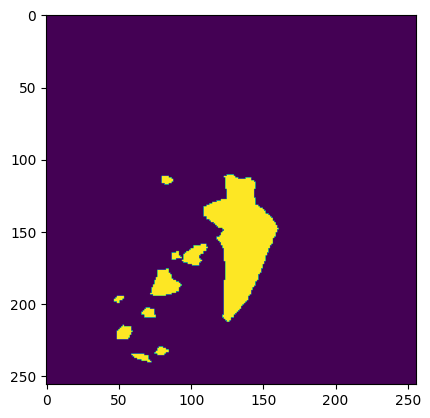

In [23]:
plt.imshow(io)

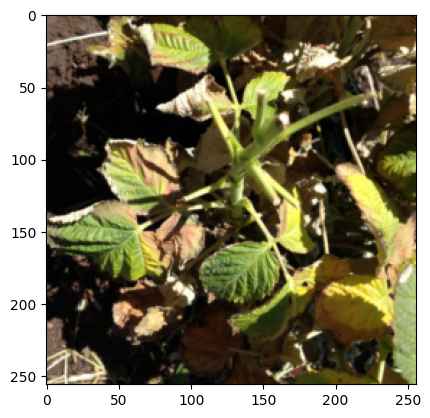

In [24]:
imag2= plt.imread("/home/chaitanya/Untitled_Folder/extracted_mlds_files/test/test/Img_919.png")
plt.imshow(imag2)

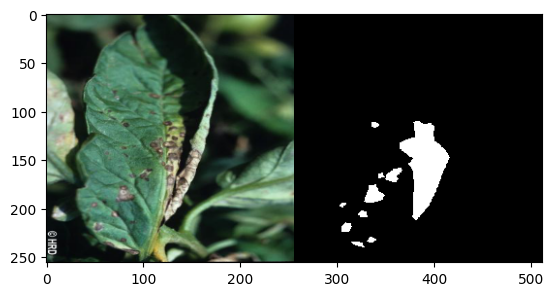

In [25]:
imag1= plt.imread("/home/chaitanya/Untitled_Folder/extracted_mlds_files/train/train/Img_0.png")
plt.imshow(imag1)

In [26]:
df3=pd.read_csv('/home/chaitanya/Untitled_Folder/extracted_mlds_files/train.csv')
df3

,id,binary_pred,segmentation_pred
0,Img_0.png,1,12230 2 12485 3 12740 5 12764 6 12996 5 13019 ...
1,Img_1.png,1,24677 5 24933 7 25188 10 25443 13 25699 14 259...
2,Img_2.png,0,Healthy
3,Img_3.png,1,117 1 373 29 628 30 884 30 1141 29 1397 29 165...
4,Img_4.png,1,1 3 20 25 257 4 277 24 382 8 513 5 534 23 636 ...
...,...,...,...
914,Img_914.png,1,19320 3 19577 6 19833 6 20089 5 20098 5 20347 ...
915,Img_915.png,1,2145 2 2401 2 2657 4 2913 8 3170 9 3426 10 368...
916,Img_916.png,1,19595 28 19849 38 20104 46 20358 55 20612 62 2...
917,Img_917.png,0,Healthy


In [27]:

# train_df = df3.drop(columns=[df3.columns[-1]])
# train_df['id'] = '/home/chaitanya/Untitled_Folder/extracted_mlds_files/train/train/' + train_df['id'].astype(str)
# train_df

In [28]:
# train_df.iloc[0,0]

In [29]:
# for i in range(1):
#     img= plt.imread(train_df.iloc[i,0])
#     img1=img[:256,:256]
#     plt.imshow(img1)
#     plt.show()
#     print(img1.shape)

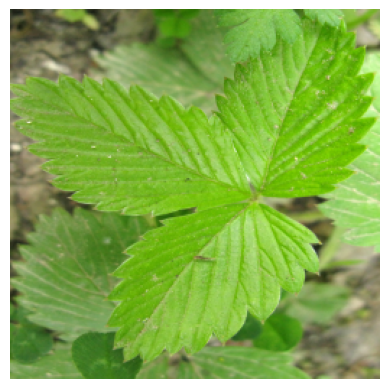

In [31]:
import matplotlib.pyplot as plt
import os

# Create a directory for the cropped images if it doesn't exist
save_directory = "/home/chaitanya/Untitled_Folder/extracted_mlds_files/train2/cropped_images"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

for i in range(919):
    
    img_path = train_df.iloc[i, 0]
    img = plt.imread(img_path)
    
    cropped_img = img[:256, :256]
    
    plt.imshow(cropped_img)
    plt.axis('off') 
    #plt.show()
    #print(cropped_img.shape)
    
    save_path = os.path.join(save_directory, "Img_{}.png".format(i))
    plt.imsave(save_path, cropped_img)


In [32]:
modified_train_df=df3.drop(columns=[df3.columns[-1]])
modified_train_df['id'] = '/home/chaitanya/Untitled_Folder/extracted_mlds_files/train2/cropped_images/' + modified_train_df['id'].astype(str)
modified_train_df

,id,binary_pred
0,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,1
1,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,1
2,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,0
3,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,1
4,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,1
...,...,...
914,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,1
915,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,1
916,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,1
917,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,0


In [33]:
modified_train_df.iloc[-1,0]

'/home/chaitanya/Untitled_Folder/extracted_mlds_files/train2/cropped_images/Img_918.png'

In [34]:
'/home/chaitanya/Untitled_Folder/extracted_mlds_files/train2/cropped_images/Img_918.png'

'/home/chaitanya/Untitled_Folder/extracted_mlds_files/train2/cropped_images/Img_918.png'

(256, 256, 4)

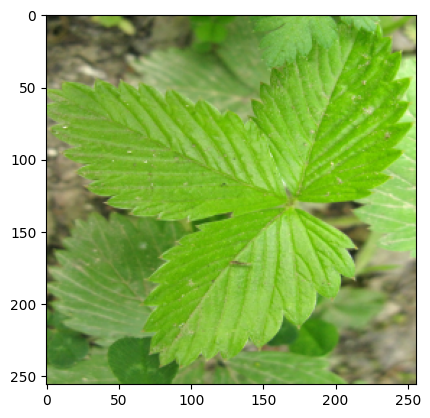

In [35]:
img=plt.imread(modified_train_df.iloc[-1,0])
plt.imshow(img)
img.shape

In [36]:
from sklearn.model_selection import train_test_split

train_df1, val_df1 = train_test_split(modified_train_df, test_size=0.2, random_state=42)

print(f"Train dataset shape: {train_df1.shape}")
print(f"Validation dataset shape: {val_df1.shape}")

Train dataset shape: (735, 2)
Validation dataset shape: (184, 2)


In [37]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


In [38]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [39]:
df2=pd.read_csv('/home/chaitanya/Untitled_Folder/extracted_mlds_files/test.csv')
df2

,id,binary_pred,segmentation_pred
0,Img_919.png,NaN,NaN
1,Img_920.png,NaN,NaN
2,Img_921.png,NaN,NaN
3,Img_922.png,NaN,NaN
4,Img_923.png,NaN,NaN
...,...,...,...
389,Img_1308.png,NaN,NaN
390,Img_1309.png,NaN,NaN
391,Img_1310.png,NaN,NaN
392,Img_1311.png,NaN,NaN


In [40]:
df2.columns[-1]


'segmentation_pred'

In [41]:
test_df= df2.drop(columns=[df2.columns[-1]])
test_df['id'] = '/home/chaitanya/Untitled_Folder/extracted_mlds_files/test/test/'+test_df['id'].astype(str)
test_df

,id,binary_pred
0,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
1,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
2,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
3,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
4,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
...,...,...
389,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
390,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
391,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN
392,/home/chaitanya/Untitled_Folder/extracted_mlds_f...,NaN


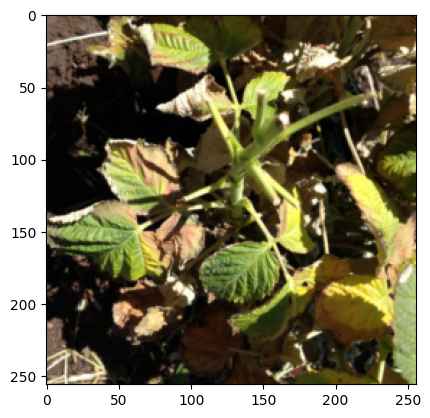

In [42]:
ig=plt.imread(test_df.iloc[0,0])
plt.imshow(ig)

In [43]:
train_dataset = CustomDataset(train_df1, transform=transform)
val_dataset = CustomDataset(val_df1, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

In [44]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader =DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
len(train_loader),len(val_loader),len(test_loader)

(23, 6, 13)

torch.Size([224, 224])

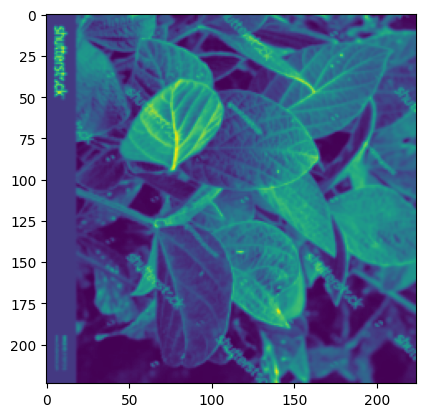

In [46]:
img=train_dataset[0][0][0]
plt.imshow(img)
img.shape


In [47]:
model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(num_ftrs, 1)


/home/chaitanya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chaitanya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda', index=0)

In [49]:
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.BCEWithLogitsLoss()  
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 1/10, Loss: 0.4692, Accuracy: 0.7714, Val Loss: 0.1880, Val Accuracy: 0.9457
Epoch 2/10, Loss: 0.1644, Accuracy: 0.9442, Val Loss: 0.1758, Val Accuracy: 0.9402
Epoch 3/10, Loss: 0.0791, Accuracy: 0.9728, Val Loss: 0.1235, Val Accuracy: 0.9620
Epoch 4/10, Loss: 0.0375, Accuracy: 0.9878, Val Loss: 0.1048, Val Accuracy: 0.9620
Epoch 5/10, Loss: 0.0198, Accuracy: 0.9918, Val Loss: 0.1235, Val Accuracy: 0.9620
Epoch 6/10, Loss: 0.0489, Accuracy: 0.9823, Val Loss: 0.0971, Val Accuracy: 0.9674
Epoch 7/10, Loss: 0.0285, Accuracy: 0.9905, Val Loss: 0.2398, Val Accuracy: 0.9457
Epoch 8/10, Loss: 0.0110, Accuracy: 0.9973, Val Loss: 0.1730, Val Accuracy: 0.9565
Epoch 9/10, Loss: 0.0113, Accuracy: 0.9973, Val Loss: 0.2265, Val Accuracy: 0.9620
Epoch 10/10, Loss: 0.0129, Accuracy: 0.9959, Val Loss: 0.1619, Val Accuracy: 0.9620


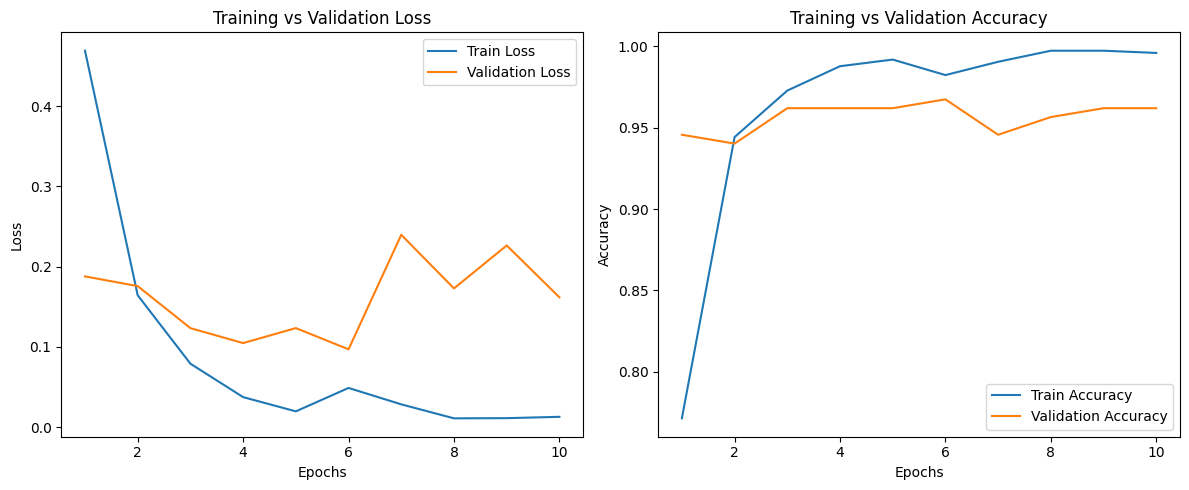

In [50]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # For plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).round()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted = torch.sigmoid(outputs).round()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [61]:
from sklearn.metrics import classification_report
import torch

def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()  
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert lists to numpy arrays for sklearn functions
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


test_model(model, test_loader)


/home/chaitanya/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [54]:
def get_predictions(model, test_loader):
    model.eval()  
    all_preds = []
    image_paths = []

    with torch.no_grad():
        for inputs, paths in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()  
            all_preds.extend(preds.cpu().numpy())
            image_paths.extend(paths)

    return all_preds, image_paths

predictions, image_paths = get_predictions(model, test_loader)

result_df = pd.DataFrame({
    'image_path': image_paths,
    'prediction': np.array(predictions).flatten()
})
result_csv_path = '/home/chaitanya/Untitled_Folder/extracted_mlds_files/test/test_predictions.csv'  
result_df.to_csv(result_csv_path, index=False)

print(f"Predictions saved to {result_csv_path}")

Predictions saved to /home/chaitanya/Untitled_Folder/extracted_mlds_files/test/test_predictions.csv


In [3]:
test_pred_df = pd.read_csv("/home/chaitanya/Untitled_Folder/extracted_mlds_files/test/test_predictions.csv")
test_pred_df[test_pred_df['prediction']==1]


,image_path,prediction
3,"tensor(nan, dtype=torch.float64)",1.0
4,"tensor(nan, dtype=torch.float64)",1.0
11,"tensor(nan, dtype=torch.float64)",1.0
14,"tensor(nan, dtype=torch.float64)",1.0
18,"tensor(nan, dtype=torch.float64)",1.0
...,...,...
384,"tensor(nan, dtype=torch.float64)",1.0
387,"tensor(nan, dtype=torch.float64)",1.0
388,"tensor(nan, dtype=torch.float64)",1.0
389,"tensor(nan, dtype=torch.float64)",1.0


In [4]:
test_pred_df

,image_path,prediction
0,"tensor(nan, dtype=torch.float64)",0.0
1,"tensor(nan, dtype=torch.float64)",0.0
2,"tensor(nan, dtype=torch.float64)",0.0
3,"tensor(nan, dtype=torch.float64)",1.0
4,"tensor(nan, dtype=torch.float64)",1.0
...,...,...
389,"tensor(nan, dtype=torch.float64)",1.0
390,"tensor(nan, dtype=torch.float64)",1.0
391,"tensor(nan, dtype=torch.float64)",0.0
392,"tensor(nan, dtype=torch.float64)",0.0
